# Fecha de entrega: 27/08/2022 (corresponde a clase 20)

# Algoritmo de clasificación: Random forest

# Diccionario

**BTC_metals_fv** (reducido según las conclusiones referidas en el punto 7 del documento "Primera Entrega")

- **Date**: fecha en YYYY-MM-DD (object [ns])
- **Price**: precio de cierre de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- **Open**: precio de apertura de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- **High**: precio más alto de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- **Low**: precio más bajo de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- **Vol.**: volumen de BTC (Número de intercambios) en el día de la fecha (float) (Variable numérica continua)
- **Percentage_diff**: diferencia porcentual del precio de BTC en la fecha [x+1] con respecto a la fecha [x] (float) (Variable numérica continua) 
- **Target**: 1 indica que en el día de la fecha el precio de BTC subió, y 0 que el precio bajó (float) (Se la tratará como variable categórica)
- **Price_gold**: indica el precio de cierre del oro en el día de la fecha (float) (USD) (variable numérica continua)
- **Perc_diff_gold**: diferencial porcentual del precio del oro de la fecha [x+1] con respecto a la fecha [x] (float) (variable numérica continua)
- **Price_copper**: indica el precio de cierre del cobre en el día de la fecha (float) (USD) (variable numérica continua)
- **Perc_diff_copper**:  diferencial porcentual del precio del cobre en la fecha [x+1] con respecto a la fecha [x] (float) (variable numérica continua)
- **Price_platinum**: indica el precio de cierre del platino en el día de la fecha (float) (USD) (variable numérica continua)
- **Perc_diff_platinum**:  diferencial porcentual del precio del platino en la fecha [x+1] con respecto a la fecha [x] (float) (variable numérica continua)
- **Price_palladium**: indica el precio de cierre del paladio en el día de la fecha (float) (USD) (variable numérica continua)
- **Perc_diff_palladium**: diferencial porcentual del precio del paladio en la fecha [x+1] con respecto a la fecha [x] (float) (variable numérica continua)
- **Trend**: indica la tendencia de la serie de tiempo en relación con la variable [Price] (float) (variable numérica continua)
- **Residuals**: indica los residuales de la serie de tiempo en relación con la variable [Price] (float) (variable numérica continua)

# Librerías

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas_profiling
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.cm import ScalarMappable

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('darkgrid')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

C:\Users\lucia\anaconda3\envs\acjup\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\lucia\anaconda3\envs\acjup\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Data acquisition

In [2]:
def gdriveColabPath(sharing_url):
  file_id=sharing_url.split('/')[-2]
  dwn_url='https://drive.google.com/uc?id=' + file_id
  return dwn_url

## Adquiriendo BTC_metals

In [3]:
# Se carga la base de datos de BTC_metals desde la carpeta compartida en el Google Drive
sharing_url = "https://drive.google.com/file/d/1lU7RCERkjbbrHv8OiQb2EI4PIpk_3BW0/view?usp=sharing"

In [4]:
dwn_url=gdriveColabPath(sharing_url)
BTC_metals_fv_df = pd.read_csv(dwn_url, sep=";", decimal=".")
BTC_metals_fv_df.head()

,Date,Price,Open,High,Low,Vol.,Percentage_diff,Target,Price_gold,Perc_diff_gold,Price_copper,Perc_diff_copper,Price_aluminium,Perc_diff_aluminium,Trend,Residuals
0,2014-06-23,591.2,603.6,604.7,582.9,2650.0,-2.06,0.0,1318.0,0.14,3.146,0.90,1892.5,0.21,NaN,NaN
1,2014-06-24,588.8,591.2,595.7,585.4,3080.0,-0.41,0.0,1320.9,0.22,3.147,0.03,1901.0,0.45,NaN,NaN
2,2014-06-25,568.5,588.8,589.6,566.9,3090.0,-3.45,0.0,1322.2,0.10,3.160,0.41,1903.5,0.13,NaN,NaN
3,2014-06-26,582.7,568.5,582.7,565.8,4150.0,2.51,1.0,1316.1,-0.46,3.161,0.03,1898.0,-0.29,590.300000,15.543527
4,2014-06-27,602.2,582.7,603.9,580.1,3390.0,3.35,1.0,1319.0,0.22,3.149,-0.38,1885.0,-0.68,596.571429,20.802061


# Data wrangling

## Análisis pre-modelado

In [5]:
# Registros y columnas
BTC_metals_fv_df.shape

(2949, 16)

In [6]:
BTC_metals_fv_df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Percentage_diff',
       'Target', 'Price_gold', 'Perc_diff_gold', 'Price_copper',
       'Perc_diff_copper', 'Price_aluminium', 'Perc_diff_aluminium', 'Trend',
       'Residuals'],
      dtype='object')

In [7]:
# Conociendo los tipos de datos de las variables
BTC_metals_fv_df.dtypes

Date                    object
Price                  float64
Open                   float64
High                   float64
Low                    float64
Vol.                   float64
Percentage_diff        float64
Target                 float64
Price_gold             float64
Perc_diff_gold         float64
Price_copper           float64
Perc_diff_copper       float64
Price_aluminium        float64
Perc_diff_aluminium    float64
Trend                  float64
Residuals              float64
dtype: object

In [8]:
# Columnas y cantidad de registros
BTC_metals_fv_df.count()

Date                   2949
Price                  2949
Open                   2949
High                   2949
Low                    2949
Vol.                   2949
Percentage_diff        2949
Target                 2949
Price_gold             2949
Perc_diff_gold         2949
Price_copper           2949
Perc_diff_copper       2949
Price_aluminium        2949
Perc_diff_aluminium    2949
Trend                  2943
Residuals              2943
dtype: int64

In [9]:
# Se detectan valores NaN
BTC_metals_fv_df.isnull().sum()

Date                   0
Price                  0
Open                   0
High                   0
Low                    0
Vol.                   0
Percentage_diff        0
Target                 0
Price_gold             0
Perc_diff_gold         0
Price_copper           0
Perc_diff_copper       0
Price_aluminium        0
Perc_diff_aluminium    0
Trend                  6
Residuals              6
dtype: int64

**Observación 1: missing values**

Se observaron 12 missing values en "BTC_metals_fv.csv" => 6 valores NaN en la variable [Trend] y 6 valores NaN en la variable [Residuals]. 

Esto implica la necesidad de tomar una decisión con respecto a este tipo de valores en una instancia previa al modelado. 

Se descarta rellenar los missing values con promedios de los valores de los registros previos y/o posteriores a los NaN por varias razones:

1. Dado que en ambas variables, 3 de los 6 valores NaN se encuentran al principio y los restantes tres al final de la serie, no se puede hacer un promedio con valores anteriores y posteriores en el marco de la serie de tiempo.


2. Ya se comprobó en "Algoritmo de clasificación (Decision Tree + BTC_metals).ipynb" que los modelos Decision Tree no aceptan missing values. 

Solución:

- Entendiendo que Random Forest (sumatoria de Decision Trees) no aceptan missing values, y que el resultado de haber eliminado los NaN en el modelo de Decision Tree arriba referido no generó grandes diferencias en lo atienente al accuracy de la predicción realizada, también este caso particular se procede a su eliminación. 

**Observación 2: modificación de la variable [Target]**
    
En "Algoritmo de clasificación (Decision Tree + BTC_metals).ipynb" se reflexionó sobre la necesidad de realizar un shift (-1) en la variable [Target], dado que en cualquier caso real que se intente predecir si el precio de BTC subirá o bajará en el corto plazo, el científico de datos no posee el valor de [Price] (precio de cierre de BTC) del nuevo registro que busca predecir. Al respecto existen dos soluciones:

1. Eliminar las variables [Price], [High], [Low] y solo dejar la variable [Open] (el único dato real que se tiene al momento de predecir), a saber, una situación que eliminaría variables con una muy fuerte correlación positiva entre sí.


2. Realizar el shift mencionado arriba con respecto a los registros de la variable [Target]. Así se podrían conservar las columnas expresadas en "1" (Observación 2). Se entiende que luego de la modificación el modelo ya estaría orientado a predecir si el precio de BTC subirá o bajará en el futuro. De esta forma también se evita eliminar [Percentage_diff] tal como fue eliminado en "Algoritmo de clasificación (Decision Tree + BTC_metals).ipynb".

Nota importante: 
- Dado que se está intentando predecir el comportamiento de una serie de tiempo, se debe entrenar el modelo para predecir el futuro, se recuerda al lector que al momento de intentar predecir el comportamiento futuro de BTC con los modelos que se desarrollarán debajo, se deben introducir los datos del registro inmediatamente anterior al momento que se intenta predecir, y por eso, el modelo debe ser entrenado siguiendo esa misma lógica.

## Manipulación final para el modelado

Se reindexa el data set que se modelará a fin de que la variable [Date] funcione como nuevo índice de la base de datos.

In [10]:
# Se crea una copia de BTC_metals_fv_df y se la reindexa con la variable [Date] como nuevo índice
BTC_metals = BTC_metals_fv_df.set_index("Date")

In [11]:
BTC_metals.tail()

,Price,Open,High,Low,Vol.,Percentage_diff,Target,Price_gold,Perc_diff_gold,Price_copper,Perc_diff_copper,Price_aluminium,Perc_diff_aluminium,Trend,Residuals
Date,,,,,,,,,,,,,,,
2022-07-15,20825.1,20586.1,21178.1,20393.4,164670.0,1.16,1.0,1703.60,-0.13,3.2455,0.49,2344.0,0.69,20787.614286,52.659204
2022-07-16,21209.9,20825.2,21561.3,20484.4,136890.0,1.85,1.0,1703.60,0.00,3.2455,0.00,2344.0,0.00,21370.371429,-160.520267
2022-07-17,20785.6,21209.8,21654.4,20755.2,132810.0,-2.00,0.0,1703.60,0.00,3.2455,0.00,2344.0,0.00,NaN,NaN
2022-07-18,22525.8,20785.6,22714.9,20770.6,279720.0,8.37,1.0,1710.20,0.39,3.3167,2.18,2435.0,3.88,NaN,NaN
2022-07-19,23410.2,22529.3,23757.3,21581.8,308910.0,3.93,1.0,1708.05,-0.13,3.2965,-0.61,2386.0,-2.01,NaN,NaN


In [12]:
# Se realiza el shift de la variable Target (explicado arriba - Observación 2)
BTC_metals ["Target"] = BTC_metals ["Target"].shift(-1)

In [13]:
# Se eliminan todos los registro NaN (explicado arriba -> Observación 1)
BTC_metals = BTC_metals.dropna()

In [14]:
BTC_metals.isnull().sum()

Price                  0
Open                   0
High                   0
Low                    0
Vol.                   0
Percentage_diff        0
Target                 0
Price_gold             0
Perc_diff_gold         0
Price_copper           0
Perc_diff_copper       0
Price_aluminium        0
Perc_diff_aluminium    0
Trend                  0
Residuals              0
dtype: int64

In [15]:
BTC_metals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2943 entries, 2014-06-26 to 2022-07-16
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                2943 non-null   float64
 1   Open                 2943 non-null   float64
 2   High                 2943 non-null   float64
 3   Low                  2943 non-null   float64
 4   Vol.                 2943 non-null   float64
 5   Percentage_diff      2943 non-null   float64
 6   Target               2943 non-null   float64
 7   Price_gold           2943 non-null   float64
 8   Perc_diff_gold       2943 non-null   float64
 9   Price_copper         2943 non-null   float64
 10  Perc_diff_copper     2943 non-null   float64
 11  Price_aluminium      2943 non-null   float64
 12  Perc_diff_aluminium  2943 non-null   float64
 13  Trend                2943 non-null   float64
 14  Residuals            2943 non-null   float64
dtypes: float64(15)
memory usage:

# Modelado (Random forest)

**...Recordando que...**

*Objetivo general del proyecto*

I.	Diseñar diversos modelos de machine learning capaces de predecir con cierto grado de previsibilidad positiva (>50/55%) el dinamismo del precio de Bitcoin en el corto plazo, es decir, si el precio de este criptoactivo subirá o bajará en la temporalidad estudiada (1 día).

**...Recordando que...**

*Objetivo específico del proyecto*

III.	Diseñar diversos modelos de machine learning capaces de predecir con cierto grado de previsibilidad positiva (>50/55%) y a corto plazo, el movimiento alcista o bajista del precio de BTC.

**Explicación**:

En lo que sigue se procederá a realizar varios modelos supervisados de clasificación de tipo "Random forest". 

Estos serán configurados con diversos hiperparámetros a fin de encontrar el resultado más óptimo para este data set.

La variable target del modelo es la columna [Target] de BTC_metals.

## Modelo 1

In [16]:
# Se separa X e y
X = BTC_metals.drop(["Target"], axis=1)
y = BTC_metals["Target"]

In [17]:
# Se separa la data en train (70%) y test (30%)
# Se decide aplicar stratify
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                        stratify=y,
                                        test_size=0.30,
                                        random_state=11)

In [18]:
# Se crea el Random forest
model = RandomForestClassifier(random_state=11, n_estimators=200,
                               class_weight="balanced", max_features="log2")

In [19]:
# Se entrena al Random forest
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=200, random_state=11)

In [20]:
#Prediccion en Train

y_train_pred = model.predict(X_train) 
train_accuracy = accuracy_score(y_train, y_train_pred)

print('% de aciertos sobre el set de entrenamiento:',train_accuracy)

% de aciertos sobre el set de entrenamiento: 1.0


In [21]:
# Se busca conocer el grado de prediccion del modelo utilizando el Test
y_test_pred = model.predict(X_test)

In [22]:
# Se calcula el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación es:',test_accuracy)

% de aciertos sobre el set de evaluación es: 0.6477916194790487


Observaciones:

- Dado que el % de aciertos en el set de entrenamiento es 100% y el porcentaje de aciertos en el set de evaluación es 64,78% se entiende que hay overfitting. Para corregirlo se intentará modificar algunos hiperparámetros.

## Modelo 2

In [23]:
# Se crea un nuevo Random forest con otros hiperparámetros
model = RandomForestClassifier(random_state=11,
                               n_estimators=100,
                               class_weight="balanced", 
                               max_features="log2")
model.fit(X_train, y_train)

#Prediccion en Train
y_train_pred = model.predict(X_train) 
train_accuracy = accuracy_score(y_train, y_train_pred)

print('% de aciertos sobre el set de entrenamiento:',train_accuracy)

#Prediccion en Test
y_test_pred = model.predict(X_test) 
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 1.0
% de aciertos sobre el set de evaluación: 0.6353340883352209


Observaciones:

- Las modificaciones realizadas no generaron una reducción de la diferencia entre el % de aciertos en el set de entrenamiento y el % de aciertos en el set de evaluación. Se utilizará RandomizedSearchCV a fin de intentar mejor el resultado.

## Hyperparameter tuning

In [24]:
# Se instancia el modelo
random_forest = RandomForestClassifier() 

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Se definen los parámetros de búsqueda
params = {'random_state': np.arange(1,10000,10),
    'n_estimators': [100, 200, 500,1000,10000],
    'max_depth': [1,2,3,4],
    'class_weight':['balanced'], 
    'max_features': ['log2']}

grid_random_forest = RandomizedSearchCV(random_forest, params, scoring = 'neg_mean_absolute_error', n_iter=100, cv=5, verbose=2)

In [26]:
# Se entrena el modelo
grid_random_forest.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END class_weight=balanced, max_depth=1, max_features=log2, n_estimators=10000, random_state=2001; total time=  18.5s
[CV] END class_weight=balanced, max_depth=1, max_features=log2, n_estimators=10000, random_state=2001; total time=  16.9s
[CV] END class_weight=balanced, max_depth=1, max_features=log2, n_estimators=10000, random_state=2001; total time=  16.8s
[CV] END class_weight=balanced, max_depth=1, max_features=log2, n_estimators=10000, random_state=2001; total time=  18.5s
[CV] END class_weight=balanced, max_depth=1, max_features=log2, n_estimators=10000, random_state=2001; total time=  17.5s
[CV] END class_weight=balanced, max_depth=1, max_features=log2, n_estimators=1000, random_state=3761; total time=   1.5s
[CV] END class_weight=balanced, max_depth=1, max_features=log2, n_estimators=1000, random_state=3761; total time=   1.6s
[CV] END class_weight=balanced, max_depth=1, max_features=log2, n_estimators=1000, ra

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [1, 2, 3, 4],
                                        'max_features': ['log2'],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         10000],
                                        'random_state': array([   1,   11,   21,   31,   41,   51,   61,   71,   81,   91,  101,
        111,  121,  131,  141,  151,  161,  171,  181,  191,  201,  211,
        221,  231,  241,  251,  261,  271,  281,  291,  301,  311,  321,
        33...
       9351, 9361, 9371, 9381, 9391, 9401, 9411, 9421, 9431, 9441, 9451,
       9461, 9471, 9481, 9491, 9501, 9511, 9521, 9531, 9541, 9551, 9561,
       9571, 9581, 9591, 9601, 9611, 9621, 9631, 9641, 9651, 9661, 9671,
       9681, 9691, 9701, 9711, 9721, 9731, 9741, 9751, 9761, 9771, 9781,
       9791, 9801, 9811, 9821, 9831, 9841, 9851, 9861, 9871, 9881, 9891,
       9901, 9911, 9921, 9931, 9941, 9951, 9961, 9971, 9981, 9991])},
                   scoring='neg_mean_absolute_error', verbose=2)

In [27]:
# Se obtiene el mejor modelo
grid_random_forest.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       max_features='log2', n_estimators=500,
                       random_state=1581)

In [28]:
# Se obtiene la predicción en Train
y_train_pred = grid_random_forest.predict(X_train) 

# Se obtiene la predicción en Test
y_test_pred = grid_random_forest.predict(X_test)

In [29]:
# Se calcula el accuracy en Train
train_accuracy = accuracy_score(y_train, y_train_pred)

# Se calcula el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de entrenamiento:', train_accuracy)
print('% de aciertos sobre el set de evaluación:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.6893203883495146
% de aciertos sobre el set de evaluación: 0.6500566251415628


Observación:

- RandomizedSearchCV mejoró el overfitting anterior.
- En el mejor de los casos se obtuvo 65,00% de aciertos de valores futuros.

[[279 138]
 [171 295]]


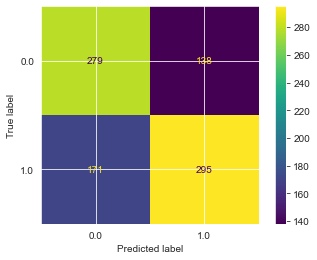

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Predicciones
predictions = grid_random_forest.predict(X_test)

#Matriz de Confusión
print(confusion_matrix(y_test, predictions))

#Ploteamos la Matriz
plot_confusion_matrix(grid_random_forest, X_test, y_test)
plt.show()

Observaciones:
- Al modelo le cuesta encontrar las clases.
- El modelo clasifica un elevado número de falsos negativos y positivos.

Accuracy of the classifier is: 0.6500566251415628
Precision Score of the classifier is: 0.6812933025404158
Recall Score of the classifier is: 0.6330472103004292
F1 Score of the classifier is: 0.6562847608453838
AUC for our classifier is: 0.6950731260485175


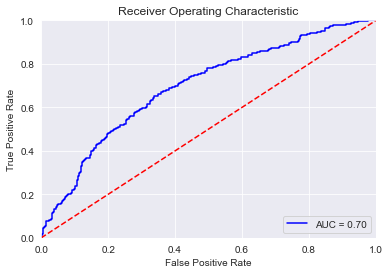

In [32]:
# Accuracy
print(f"Accuracy of the classifier is: {accuracy_score(y_test, predictions)}")

# Precision
from sklearn.metrics import precision_score
print(f"Precision Score of the classifier is: {precision_score(y_test, predictions)}")

# Recall
from sklearn.metrics import recall_score
print(f"Recall Score of the classifier is: {recall_score(y_test, predictions)}")

# Calculo del F1 score
from sklearn.metrics import f1_score
print(f"F1 Score of the classifier is: {f1_score(y_test, predictions)}")

#Template CURVA - ROC

from sklearn.metrics import roc_curve, auc

class_probabilities = grid_random_forest.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()